In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision
import torch.utils.data as data
from torchvision.utils import make_grid
from torch.optim import Adam
import sys
sys.path.insert(1, '../../torch-helper')
from pthelper import ModelWrapper
from pthelper.utils import DataLoaderWrapper, get_default_device
from pthelper.vision import predict
from pthelper.validation import top_confused, classification_report, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
data_dir = 'synthetic_digits/'

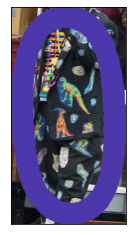

In [4]:
img = plt.imread('synthetic_digits/imgs_train/0/0_00000.jpg')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
img.shape

(371, 196, 3)

In [6]:
bs = 16
RESHAPE_IMG_DIM = (50, 50)

In [7]:
transform = transforms.Compose([
    transforms.Resize(RESHAPE_IMG_DIM),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4828, 0.4603, 0.4319],
                         std=[0.2625, 0.2595, 0.2702])
])
train_img_data = torchvision.datasets.ImageFolder(root=data_dir+'imgs_train', transform=transform)
loader = data.DataLoader(train_img_data, batch_size=100)
num_of_pixels_per_channel = len(train_img_data) * RESHAPE_IMG_DIM[0] * RESHAPE_IMG_DIM[1]

total_sum = [0]*3
for xb, yb in loader:
#     print(.shape)
    for i in range(3):
        total_sum[i] += xb[:, i, :, :].sum()
mean = torch.tensor([channel_sum / num_of_pixels_per_channel for channel_sum in total_sum])

sum_of_squared_error = [0]*3
for xb, yb in loader:
    for i in range(3):
        sum_of_squared_error[i] += ((xb[:, i, :, :] - mean[i]).pow(2)).sum()
std = torch.sqrt(torch.tensor([channel_sum_of_squared_error / num_of_pixels_per_channel for channel_sum_of_squared_error in sum_of_squared_error]))

mean, std

(tensor([-0.0002, -0.0001,  0.0002]), tensor([1.0000, 0.9998, 1.0000]))

In [8]:
transform = {'train': transforms.Compose([
    transforms.Resize(RESHAPE_IMG_DIM),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(60),
#     transforms.RandomErasing(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4828, 0.4603, 0.4319],
                         std=[0.2625, 0.2595, 0.2702])
                    ]),
             'val': transforms.Compose([
    transforms.Resize(RESHAPE_IMG_DIM),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0408, 0.0411, 0.0402],
                         std=[0.1474, 0.1483, 0.1460])
                 ])
    }
train_dataset = torchvision.datasets.ImageFolder(root=data_dir+'/imgs_train', transform=transform['train'])
val_dataset = torchvision.datasets.ImageFolder(root=data_dir+'/imgs_valid', transform=transform['val'])

train_dataloader = data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=2*bs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([8, 0, 0, 4, 8, 2, 8, 4, 3, 2, 4, 3, 3, 6, 5, 1])


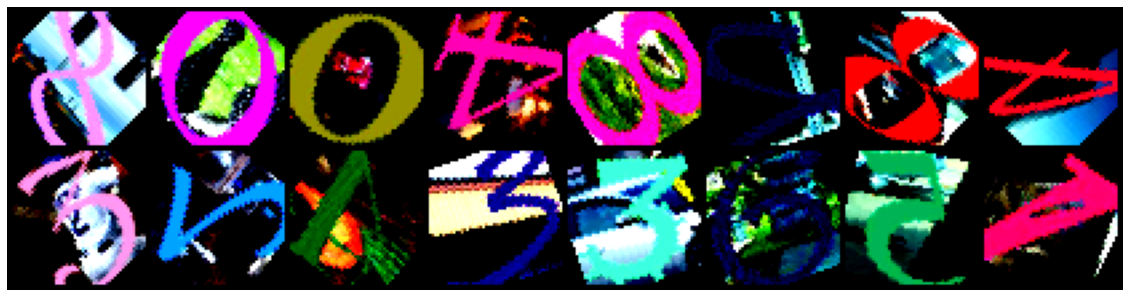

In [9]:
for batch in train_dataloader:
    xb, yb = batch
    print(yb)
    plt.figure(figsize=(20, 8))
    plt.imshow(make_grid(xb, nrow=8).permute((1, 2, 0)))
    plt.axis('off')
    break
plt.show()

In [10]:
print('Running on device ->', get_default_device())

Running on device -> cuda


## Custom Model

Creating a model with 1 residual network with batch normaliztion.

In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3)
            
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3),
        )
        self.res_1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=2048, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(),
            nn.MaxPool2d(3)
        )
        
        self.linear_model = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )        
        
    def forward(self, xb):
        batch_size = xb.shape[0]
        
        # Pass through cnn layers
        out = self.conv_1(xb)
        out = self.conv_2(out)
        out = self.res_1(out) + out
        out = self.conv_3(out)
        
        # Flatten for linear layer
        out = out.view(batch_size, -1)
        
        # Pass through linear layers
        out = self.linear_model(out)
        
        return out

In [12]:
lr = 0.01
model = CNNModel()
opt = torch.optim.SGD(model.parameters(), lr)
criterion = nn.CrossEntropyLoss()

In [13]:
model = ModelWrapper(model, opt, criterion, pred_func=nn.Softmax(dim=1), output_selection_func='argmax')
model.model_summary()

CNNModel(
  (conv_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (res_1): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_3): Sequential(
    (0): Conv2d(512, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_model): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=

In [14]:
train_dataloader = DataLoaderWrapper(train_dataloader)
val_dataloader = DataLoaderWrapper(val_dataloader)

In [15]:
model.performance_stats(val_dataloader)

loss -> 2.3063228130340576   acc -> 0.09950000047683716


In [16]:
epoch = 60
model.fit(epoch, train_dl=train_dataloader, val_dl=val_dataloader)

epoch -> 1   train loss -> 2.2861194610595703   train acc -> 0.12929999828338623   val loss -> 2.2633678913116455   val acc -> 0.15649999678134918
epoch -> 2   train loss -> 2.052340269088745   train acc -> 0.24490000307559967   val loss -> 2.04366397857666   val acc -> 0.23800000548362732
epoch -> 3   train loss -> 1.6621665954589844   train acc -> 0.41119998693466187   val loss -> 1.6593865156173706   val acc -> 0.4490000009536743
epoch -> 4   train loss -> 1.2956539392471313   train acc -> 0.5447999835014343   val loss -> 1.5535283088684082   val acc -> 0.5254999995231628
epoch -> 5   train loss -> 1.0249017477035522   train acc -> 0.6348000168800354   val loss -> 0.6859813332557678   val acc -> 0.7764999866485596
epoch -> 6   train loss -> 0.8361920714378357   train acc -> 0.7063000202178955   val loss -> 0.6056984663009644   val acc -> 0.8080000281333923
epoch -> 7   train loss -> 0.7033619284629822   train acc -> 0.7552000284194946   val loss -> 0.7724550366401672   val acc -> 0.

epoch -> 57   train loss -> 0.12878721952438354   train acc -> 0.9484999775886536   val loss -> 0.18215544521808624   val acc -> 0.9490000009536743
epoch -> 58   train loss -> 0.12189308553934097   train acc -> 0.9505000114440918   val loss -> 0.23293247818946838   val acc -> 0.9380000233650208
epoch -> 59   train loss -> 0.1176249235868454   train acc -> 0.9550999999046326   val loss -> 0.20433630049228668   val acc -> 0.9474999904632568
epoch -> 60   train loss -> 0.1129327267408371   train acc -> 0.9559999704360962   val loss -> 0.19393788278102875   val acc -> 0.9465000033378601


Let's look at the accuracy and loss graph.

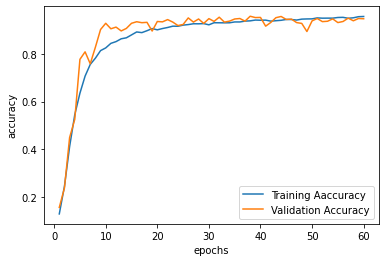

In [17]:
model.plot_acc()

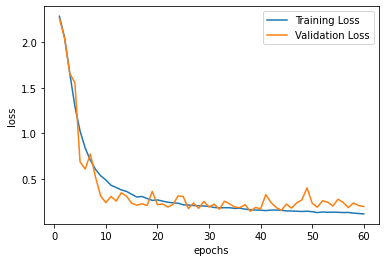

In [18]:
model.plot_loss()

Loading best model, i.e. model with least validation loss.

In [19]:
model.load_bestmodel()

In [20]:
model.performance_stats(val_dataloader)

loss -> 0.14188498258590698   acc -> 0.9570000171661377


In [21]:
img = transform['val'](Image.open('synthetic_digits/imgs_train/0/0_00000.jpg'))
predict(model, img)

(tensor([[1.0000e+00, 2.4066e-13, 2.2980e-15, 1.2071e-15, 1.1093e-15, 6.9866e-13,
          1.2709e-09, 9.2649e-10, 3.7341e-17, 1.6029e-10]]),
 tensor([0], dtype=torch.int32),
 tensor(nan))

In [22]:
prob, pred, labels = predict(model, val_dataloader)

In [23]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       200
           1       0.96      0.94      0.95       200
           2       0.94      0.94      0.94       200
           3       0.97      0.92      0.95       200
           4       0.98      0.97      0.98       200
           5       0.93      0.95      0.94       200
           6       0.97      0.95      0.96       200
           7       0.92      0.96      0.94       200
           8       0.97      0.99      0.98       200
           9       0.93      0.96      0.95       200

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



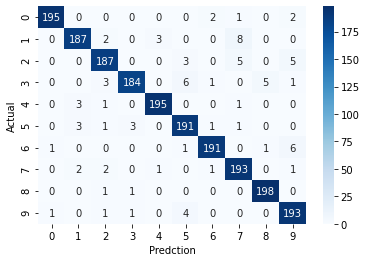

In [24]:
mat = confusion_matrix(labels, pred)
plot_confusion_matrix(mat)

In [25]:
confused = top_confused(prob, val_dataloader)

In [26]:
confused

[{'label': 9,
  'pred_label': 0,
  'pred_probability': 0.29835933446884155,
  'difference': 8.701641082763672,
  'data': tensor([[[ 5.7359,  5.7625,  5.7359,  ...,  2.9424,  3.1286,  3.2084],
           [ 5.1240,  5.3368,  5.4699,  ...,  3.6075,  3.0754,  3.1020],
           [ 4.4855,  4.5121,  4.6717,  ...,  2.7828,  3.4213,  3.1020],
           ...,
           [ 2.3039,  3.1020,  5.6295,  ...,  2.7030,  4.5387,  4.5919],
           [ 2.5167,  4.0332,  5.8157,  ...,  3.6075,  4.9644,  4.5387],
           [ 2.4901,  4.2993,  5.8955,  ...,  4.3525,  4.8846,  4.0066]],
  
          [[ 4.8265,  4.9322,  5.0380,  ...,  2.4465,  2.4465,  2.4465],
           [ 4.1654,  4.4034,  4.5620,  ...,  3.2398,  2.4994,  2.3937],
           [ 3.5043,  3.4514,  3.4778,  ...,  2.6316,  3.0812,  2.6316],
           ...,
           [ 2.1292,  1.2037,  2.4730,  ...,  1.9441,  3.6365,  3.5307],
           [ 2.1821,  1.9706,  2.5259,  ...,  2.8961,  4.0596,  3.5307],
           [ 2.0763,  2.1557,  2.5259,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


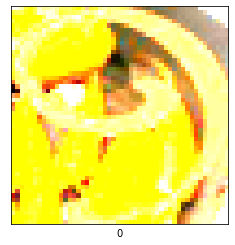

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


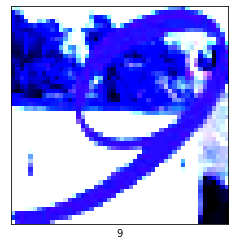

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


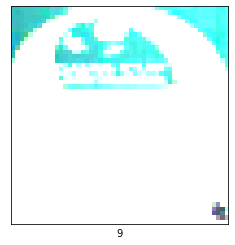

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


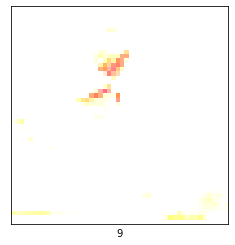

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


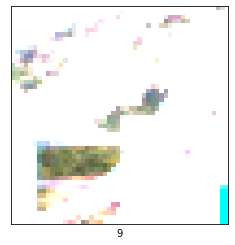

In [27]:
for c in confused:
    plt.imshow(c['data'].permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(c['pred_label'])
    plt.show()

## Transfer Learning

### DenseNet model

In [65]:
model = torchvision.models.densenet121(pretrained=True)
model.classifier = nn.Sequential(nn.Linear(1024, 10))

In [66]:
lr = 0.01
opt = torch.optim.SGD(model.parameters(), lr)
criterion = nn.CrossEntropyLoss()

In [67]:
model = ModelWrapper(model, opt, criterion, pred_func=nn.Softmax(dim=1), output_selection_func='argmax')
model.model_summary()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [68]:
train_dataloader = DataLoaderWrapper(train_dataloader)
val_dataloader = DataLoaderWrapper(val_dataloader)

In [69]:
model.performance_stats(val_dataloader)

loss -> 2.377462863922119   acc -> 0.1185000017285347


In [70]:
epoch = 2
model.freeze_to(-1)
model.fit(epoch, train_dl=train_dataloader, val_dl=val_dataloader)

epoch -> 1   train loss -> 2.056536912918091   train acc -> 0.25940001010894775   val loss -> 2.205890655517578   val acc -> 0.3005000054836273
epoch -> 2   train loss -> 1.9058514833450317   train acc -> 0.32510000467300415   val loss -> 2.133589029312134   val acc -> 0.31949999928474426


In [71]:
epoch = 2
model.freeze_to(-2)
model.set_optimizer(torch.optim.SGD(model.parameters(), lr))
model.fit(epoch, train_dl=train_dataloader, val_dl=val_dataloader)

epoch -> 1   train loss -> 1.8607444763183594   train acc -> 0.3411000072956085   val loss -> 2.258192777633667   val acc -> 0.32249999046325684
epoch -> 2   train loss -> 1.86652672290802   train acc -> 0.35010001063346863   val loss -> 2.179131507873535   val acc -> 0.33550000190734863


In [72]:
epoch = 2
model.freeze_to(-3)
model.set_optimizer(torch.optim.SGD(model.parameters(), lr))
model.fit(epoch, train_dl=train_dataloader, val_dl=val_dataloader)

epoch -> 1   train loss -> 1.8301351070404053   train acc -> 0.36169999837875366   val loss -> 1.88725745677948   val acc -> 0.4124999940395355
epoch -> 2   train loss -> 1.665271282196045   train acc -> 0.4138999879360199   val loss -> 1.7334990501403809   val acc -> 0.44600000977516174


In [73]:
lr = 0.001
epoch = 25
model.unfreeze()
opt = torch.optim.SGD(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, lr, epochs=epoch, steps_per_epoch=len(train_dataloader))
model.set_optimizer(opt)
model.fit(epoch, train_dl=train_dataloader, val_dl=val_dataloader, scheduler=scheduler)

epoch -> 1   train loss -> 1.3235894441604614   train acc -> 0.5250999927520752   val loss -> 0.9607215523719788   val acc -> 0.6554999947547913
epoch -> 2   train loss -> 0.9271658658981323   train acc -> 0.6690999865531921   val loss -> 0.49486997723579407   val acc -> 0.8190000057220459
epoch -> 3   train loss -> 0.6939495205879211   train acc -> 0.7501999735832214   val loss -> 0.32284244894981384   val acc -> 0.8930000066757202
epoch -> 4   train loss -> 0.5303176641464233   train acc -> 0.8087999820709229   val loss -> 0.24086162447929382   val acc -> 0.9179999828338623
epoch -> 5   train loss -> 0.43615493178367615   train acc -> 0.8428000211715698   val loss -> 0.18335388600826263   val acc -> 0.9350000023841858
epoch -> 6   train loss -> 0.3599499464035034   train acc -> 0.8690999746322632   val loss -> 0.13276401162147522   val acc -> 0.9539999961853027
epoch -> 7   train loss -> 0.3139728307723999   train acc -> 0.8858000040054321   val loss -> 0.12309485673904419   val acc 

In [74]:
model.load_bestmodel()

In [75]:
model.performance_stats(val_dataloader)

loss -> 0.04113367944955826   acc -> 0.9900000095367432


In [76]:
model.performance_stats(train_dataloader)

loss -> 0.07693453133106232   acc -> 0.968999981880188


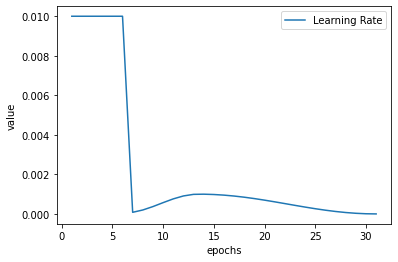

In [77]:
model.plot_lr()

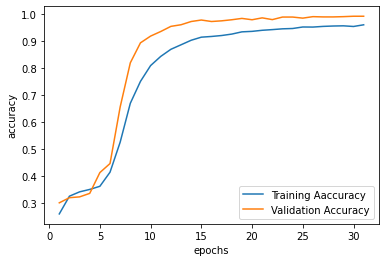

In [78]:
model.plot_acc()

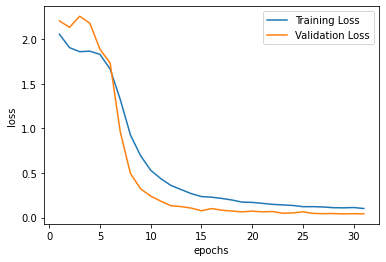

In [79]:
model.plot_loss()

In [80]:
prob, pred, label = predict(model, val_dataloader, pred_func=nn.Softmax(dim=1), output_selection_func='argmax')

In [81]:
print(classification_report(label, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.99      0.97      0.98       200
           2       0.99      0.99      0.99       200
           3       0.98      0.99      0.99       200
           4       0.99      1.00      0.99       200
           5       0.99      0.98      0.98       200
           6       1.00      0.99      1.00       200
           7       0.98      0.98      0.98       200
           8       0.99      0.99      0.99       200
           9       1.00      0.99      1.00       200

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



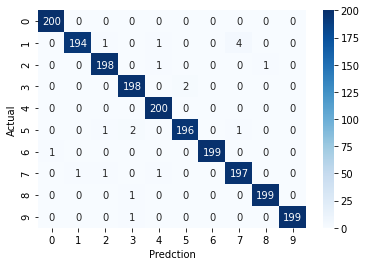

In [82]:
mat = confusion_matrix(label, pred)
plot_confusion_matrix(mat)

Looking at the the top 5 most confused images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


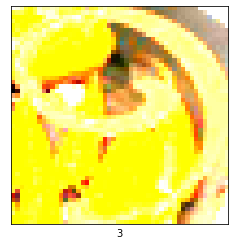

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


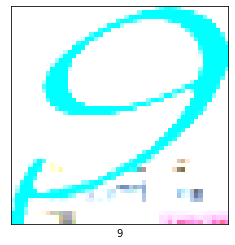

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


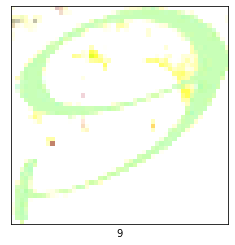

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


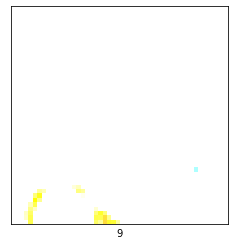

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


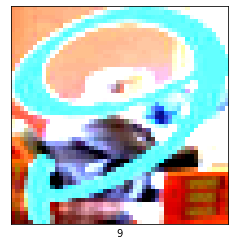

In [83]:
for it in top_confused(prob, val_dataloader):
    plt.imshow(it['data'].permute([1, 2, 0]))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(it['pred_label'])
    plt.show()